# Odio SACD library - DSD2PCM constants analysis

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=12)

## Filter Analysis
The following function extracts some properties from the given
[FIR filter](https://en.wikipedia.org/wiki/Finite_impulse_response).

In [2]:
def filter_analysis(fir_filter):
    '''
    Displaying the max value, the sum, a line-plot, Fourier transform,
    frequency response and phase response.
    '''
    coef_max = fir_filter.max()
    print(f'- max = {coef_max} ({math.log2(coef_max):.2f} bits)')

    sum_coefs = fir_filter.astype(float).sum()
    print(f'- sum = {sum_coefs:.0f} ({math.log2(sum_coefs):.10f} bits)')

    figure, (
        (filter_plot, fourier_transform),
        (freq_response, phase_response)
    ) = plt.subplots(2, 2)
    figure.set_size_inches(12, 8)
    figure.subplots_adjust(hspace=0.4)

    N = len(fir_filter)
    filter_plot.plot(fir_filter)
    filter_plot.set_title(f'Filter with {N} coefficients')

    freqs = np.fft.fftfreq(N)
    fir_filter = fir_filter.astype(float) / sum_coefs
    decibels = 20 * np.log10(np.abs(np.fft.fft(fir_filter)))
    fourier_transform.plot(
        np.concatenate((freqs[N // 2 + 1:], freqs[:N // 2])),
        np.concatenate((decibels[N // 2 + 1:], decibels[:N // 2])),
    )
    fourier_transform.set_title('Fourier transform of normalized filter')

    base_freq = 1.9375 / N  # To generate one dB value close to -3
    octave_low, octave_high, notes_per_octave = -1, 3, 12
    freqs = np.geomspace(
        base_freq * 2.0 ** octave_low,
        base_freq * 2.0 ** octave_high,
        num=(octave_high - octave_low) * notes_per_octave + 1)

    response_db, response_ph = [], []
    target_db = 10 * math.log10(0.5)  # -3.01 dB
    min_delta_db = 20 * math.log10(2.0 ** 24)  # Initial big delta (144.5 dB)
    cutoff_freq = base_freq  # Initial frequency value
    cutoff_phase = 0

    for freq in freqs:
        test_signal = np.cos(2 * np.pi * freq * np.arange(-N, N))
        filtered = np.convolve(test_signal, fir_filter.reshape(-1), 'same')

        dB = 20 * math.log10(
            np.linalg.norm(filtered[(N // 2):(N // -2)]) /
            np.linalg.norm(test_signal[(N // 2):(N // -2)]))
        response_db.append(dB)
        
        phase = math.acos(min(filtered[N], 1))  # Where n=0, should be 1
        response_ph.append(phase)

        if abs(dB - target_db) < min_delta_db:
            min_delta_db = abs(dB - target_db)
            cutoff_freq = freq
            cutoff_phase = phase

    freq_response.semilogx(freqs, response_db)
    freq_response.vlines(cutoff_freq, min(response_db), 0, colors='silver')
    freq_response.set_title(
        f'Cutoff (-3dB) at {cutoff_freq:.5f} the sampling frequency\n' +
        f'(~{1.0 / cutoff_freq:.0f} samples or ' +
        f'{(1.0 / cutoff_freq) / N:.3f}x the filter width)')

    phase_response.semilogx(freqs, response_ph)
    phase_response.vlines(cutoff_freq, 0, math.pi / 2, colors='silver')
    phase_response.set_title(
        'At cutoff (-3dB) frequency,\nthe phase shift is ' +
        f'{cutoff_phase:.3f} = {cutoff_phase/math.pi:.3f}*Pi rad')

    plt.show()

## Filter Approximation
The design of the DSD filters is unknown, but we
can try to approximate the coefficient values of a
[generalized cosine-sum window](https://en.wikipedia.org/wiki/Window_function#Cosine-sum_windows).
The below functions determine the K-th order of the cosine-sum,
and finally provide cosine coefficients of the normalized filter.

In [3]:
def precompute_cosines(N, K, debug_level=0):
    '''
    Precomputes the signed cosines for the K-th cosine-sum,
    for normalized n values from 0.5 to N-0.5, inclusive,
    and for values of k, from 0 to K, inclusive.

    Returns
        Array of size (N, K), values of -1^k * cos(2*pi * (n/N) * k)
    '''
    signs = np.power(-1, np.arange(K + 1))
    signs = np.repeat(signs.reshape(1, -1), N, axis=0)
    if debug_level >= 3:
        print(f'Signs for N, K = {N}, {K}:')
        print(signs, f' ({signs.shape[0]} rows)')

    norm_n = (np.arange(N).reshape(-1, 1) + 0.5) / N
    if debug_level >= 3:
        print(f'Normalized n values from 0.5 to {N - 0.5}:')
        print(norm_n, f' ({norm_n.shape[0]} rows)')

    k_s = np.arange(K + 1).reshape(1, -1)
    if debug_level >= 3:
        print('k values:', k_s)

    return signs * np.cos(2 * math.pi * norm_n @ k_s)

In [4]:
def solve_cosines(cosines, y, debug_level=0):
    '''
    Convenient wrapper around numpy.linalg.lstsq()
    for solving linear equations with a rectangular matrix.
    
    Returns:
        x, as an array of size (N, 1)
        residuals, as a scalar float value
    '''
    x, residuals, rank, s = np.linalg.lstsq(cosines, y, rcond=None)

    return x.reshape(-1, 1), residuals[0]

In [5]:
def compute_K(fir_filter, debug_level=0):
    '''
    This O(log(N)) algorithm determines the smallest K value
    for which the system of linear equations made of cosine-sum
    coefficients returns negligible residuals.

    Returns:
        K, the chosen integer value
    '''
    N = len(fir_filter)
    low_K, high_K, factor = 0, 2, 2

    while low_K + 1 < high_K:
        K = (low_K + high_K) // 2
        if debug_level >= 1:
            print(f'  - Testing K={K} ...')

        cosines = precompute_cosines(N, K, debug_level)
        if debug_level >= 2:
            print(f'    - cosines:')
            print(cosines)

        x, residuals = solve_cosines(cosines, fir_filter)
        if debug_level >= 2:
            print(f'    - x = {x}')
        if debug_level >= 1:
            print(f'    - residuals = {residuals}')

        if residuals > 1e-10:
            low_K = K
            high_K *= factor
        else:
            high_K = K
            factor = 1
        if debug_level >= 1:
            print(f'    - low_K, high_K = {low_K}, {high_K}')

    return high_K

In [6]:
def filter_modelization(fir_filter):
    ''' Modelizing with a K-th order cosine-sum window.

    Compute the smallest K value that has a negligible residual.
    Then, compute the K-th order cosine-sum coefficients.
    Build the approximate filter and make some error analysis.
    '''
    sum_coefs = fir_filter.astype(float).sum()
    fir_filter = fir_filter.astype(float) / sum_coefs
    K = compute_K(fir_filter, debug_level=0)
    print(f"- K = {K} (K'th order cosine-sum)")

    cosines = precompute_cosines(len(fir_filter), K, debug_level=0)
    x, residuals = solve_cosines(cosines, fir_filter)
    print("- Coefficients a_k for the K'th order cosine-sum:")
    print(x)
    signs = np.power(-1, np.arange(K + 1))
    print('  - At t=0, the cosine-sum (= -1^k*a_k, should be 0) is:',
          f'{(signs @ x)[0]:.3g}')

    new_filter = cosines @ x
    print(f'- Sum of the approximate filter coefficients = {new_filter.sum()}')

    error = new_filter - fir_filter.reshape(-1, 1)
    avg_error = math.sqrt((error * error).mean())
    print(f'- Average normalized distance = {avg_error:.3g}')
    print(f'  - upscaled to the original filter = {sum_coefs * avg_error:.2f}')
    print(f'  - bits = {math.log2(sum_coefs) + math.log2(avg_error):.2f}')

## Results
In `src/converter/converterbase.c`, the DSD filter `*18` is used for a
[decimation](https://en.wikipedia.org/wiki/Downsampling_(signal_processing))
by a factor of 8. Because of the
[Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem),
the highest frequency supported by the result will need 2
samples, which is equivalent to 16 bits before the decimation.
Consequently, the cutoff frequency of the lowpass
filter should have a period of at least 16 bits.

FILTER18COEFS:
- max = 30182209 (24.85 bits)
- sum = 268436000 (28.0000029237 bits)


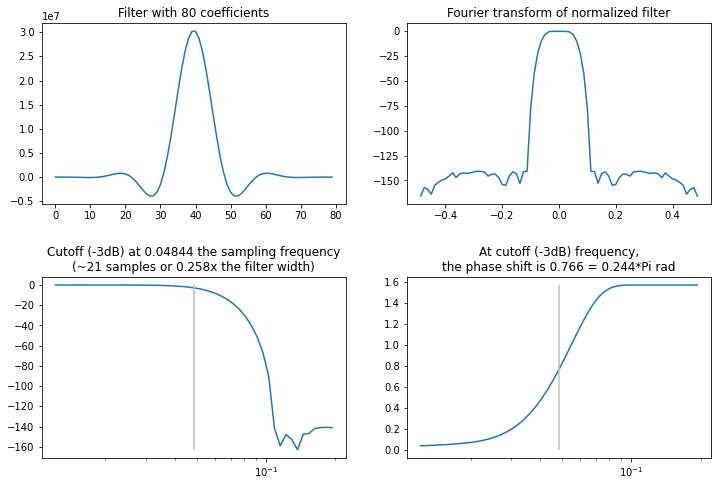

- K = 8 (K'th order cosine-sum)
- Coefficients a_k for the K'th order cosine-sum:
[[1.25000000e-02]
 [2.49999999e-02]
 [2.49121384e-02]
 [2.33331347e-02]
 [1.71814569e-02]
 [8.04055326e-03]
 [1.96444826e-03]
 [1.87766509e-04]
 [3.07179309e-06]]
  - At t=0, the cosine-sum (= -1^k*a_k, should be 0) is: -3.39e-07
- Sum of the approximate filter coefficients = 1.0
- Average normalized distance = 5.95e-09
  - upscaled to the original filter = 1.60
  - bits = 0.68


In [7]:
from constants import FILTER18COEFS

print('FILTER18COEFS:')
filter_analysis(FILTER18COEFS)
filter_modelization(FILTER18COEFS)

In `src/converter/converterbase.c`, the DSD filter `*116` is used for a
[decimation](https://en.wikipedia.org/wiki/Downsampling_(signal_processing))
by a factor of 16. Because of the
[Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem),
the highest frequency supported by the result will need 2
samples, which is equivalent to 32 bits before the decimation.
Consequently, the cutoff frequency of the lowpass
filter should have a period of at least 32 bits.

FILTER116COEFS:
- max = 15173448 (23.86 bits)
- sum = 268436008 (28.0000029667 bits)


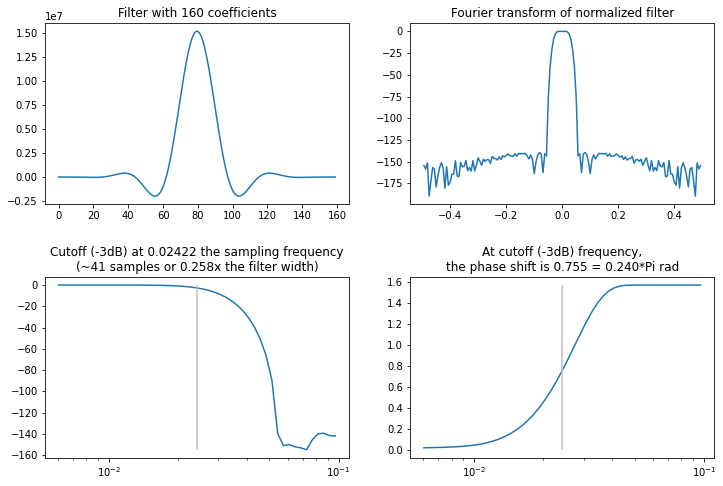

- K = 8 (K'th order cosine-sum)
- Coefficients a_k for the K'th order cosine-sum:
[[6.25000000e-03]
 [1.25000004e-02]
 [1.24561204e-02]
 [1.16699682e-02]
 [8.60529733e-03]
 [4.04001552e-03]
 [9.92614200e-04]
 [9.58008134e-05]
 [1.60225695e-06]]
  - At t=0, the cosine-sum (= -1^k*a_k, should be 0) is: -1.51e-07
- Sum of the approximate filter coefficients = 1.0
- Average normalized distance = 3.75e-09
  - upscaled to the original filter = 1.01
  - bits = 0.01


In [8]:
from constants import FILTER116COEFS

print('FILTER116COEFS:')
filter_analysis(FILTER116COEFS)
filter_modelization(FILTER116COEFS)

The following filter is not used in this library.
It comes from the
[Super Audio CD Decoder](https://sourceforge.net/projects/sacddecoder/),
which is also where the previous two filters come from.

FILTER164COEFS:
- max = 45652373 (25.44 bits)
- sum = 2147483651 (31.0000000020 bits)


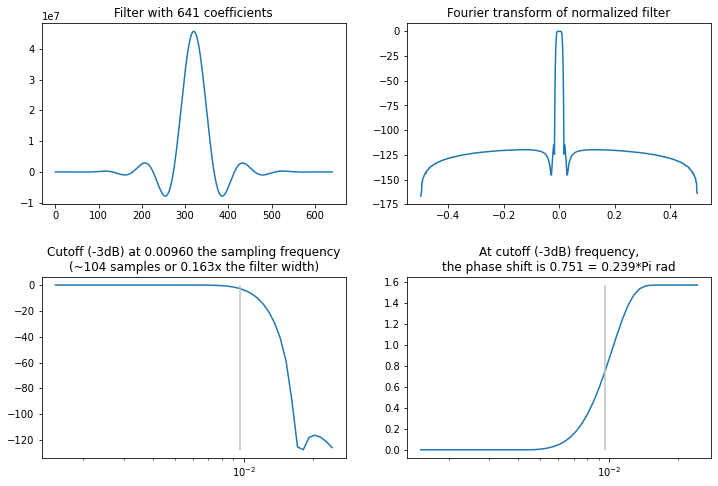

- K = 10 (K'th order cosine-sum)
- Coefficients a_k for the K'th order cosine-sum:
[[1.56006240e-03]
 [3.12013506e-03]
 [3.12013056e-03]
 [3.12012821e-03]
 [3.11351280e-03]
 [2.99136505e-03]
 [2.42109849e-03]
 [1.34566351e-03]
 [4.13449797e-04]
 [5.18315912e-05]
 [1.16465537e-06]]
  - At t=0, the cosine-sum (= -1^k*a_k, should be 0) is: 2.95e-07
- Sum of the approximate filter coefficients = 1.0000000000000002
- Average normalized distance = 2.85e-08
  - upscaled to the original filter = 61.19
  - bits = 5.94


In [9]:
from constants import FILTER164COEFS

print('FILTER164COEFS:')
filter_analysis(FILTER164COEFS)
filter_modelization(FILTER164COEFS)